In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import os, sys
import numpy as np 
# import pandas as pd 
import matplotlib.pyplot as plt
# import geopandas as gpd
import sklearn, sklearn.cross_decomposition
from sklearn.cross_decomposition import CCA
sys.path.append('../src/')
sys.path.append('../content/')
import data_utils as du
import loadpaths
path_dict_pecl = loadpaths.loadpaths()
import analysis_utils as au

Sentinel-2: (4, 128, 128) <class 'xarray.core.dataarray.DataArray'>
AlphaEarth: (64, 128, 128) <class 'xarray.core.dataarray.DataArray'>
Dynamic World: (9, 128, 128) <class 'xarray.core.dataarray.DataArray'>
WorldClimBio: <class 'dict'> dict_keys(['bio01', 'bio02', 'bio03', 'bio04', 'bio05', 'bio06', 'bio07', 'bio08', 'bio09', 'bio10', 'bio11', 'bio12', 'bio13', 'bio14', 'bio15', 'bio16', 'bio17', 'bio18', 'bio19', 'coords', 'name'])
Sentinel-2: 0 nans, 0 infs
AlphaEarth: 0 nans, 0 infs
Dynamic World: 0 nans, 0 infs


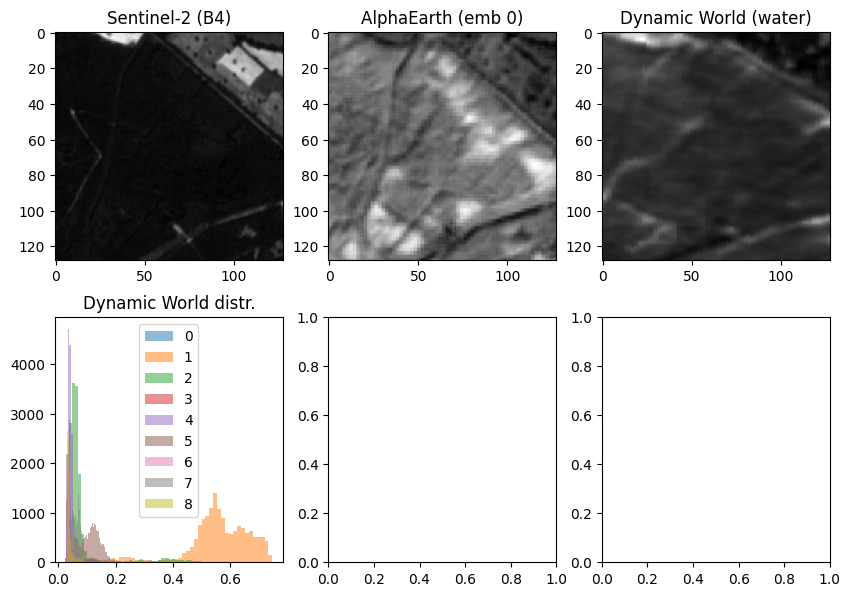

In [189]:
(data_sent, data_alpha, data_dyn, data_worldclim) = du.load_all_modalities_from_name(name='pecl-fig-3', path_folder='../content/sample_data', verbose=1)

## Check for number of nans, infs

for arr, name in zip([data_sent, data_alpha, data_dyn], ['Sentinel-2', 'AlphaEarth', 'Dynamic World']):
    print(f"{name}: {np.sum(np.isnan(arr.values))} nans, {np.sum(np.isinf(arr.values))} infs")
    
fig, ax = plt.subplots(2,3, figsize=(10,7))
ax = ax.flatten()
ax[0].imshow(np.clip(data_sent[0, ...], 0, 3000) / 3000, cmap='gray')
ax[0].set_title('Sentinel-2 (B4)')
ax[1].imshow(data_alpha[0, ...], cmap='gray')
ax[1].set_title('AlphaEarth (emb 0)')
ax[2].imshow(data_dyn[0, ...], cmap='gray')
ax[2].set_title('Dynamic World (water)')

## plot distr DW:
for i_dw in range(data_dyn.shape[0]):
    ax[3].hist(data_dyn[i_dw, ...].values.flatten(), bins=50, alpha=0.5, label=i_dw)
ax[3].set_title('Dynamic World distr.')
ax[3].legend()

(64, 16384) (9, 16384)


Text(0.5, 1.0, 'Correlation Matrix between AlphaEarth and Dynamic World')

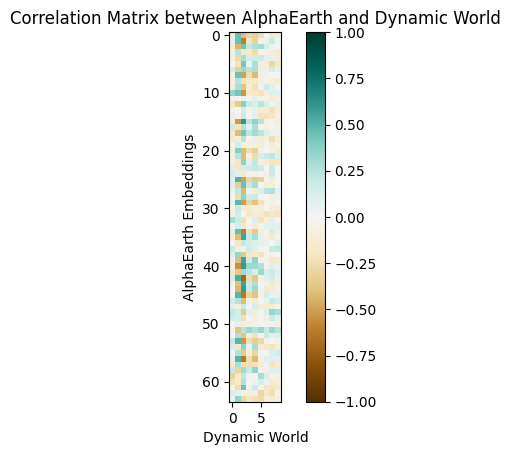

In [190]:
embed_mat = data_alpha.values.reshape(data_alpha.shape[0], -1)
dw_mat = data_dyn.values.reshape(data_dyn.shape[0], -1)
assert embed_mat.shape[1] == dw_mat.shape[1]

corr_mat = au.correlation_two_matrices(embed_mat, dw_mat)
plt.imshow(corr_mat, vmin=-1, vmax=1, cmap='BrBG')
plt.colorbar()
plt.xlabel('Dynamic World')
plt.ylabel('AlphaEarth Embeddings')
plt.title('Correlation Matrix between AlphaEarth and Dynamic World')


In [191]:
np.sort(corr_mat.flatten())[-10:]

array([0.49612114, 0.4999725 , 0.5014051 , 0.51883596, 0.5589825 ,
       0.5615447 , 0.56424636, 0.5880321 , 0.58956486, 0.60848534],
      dtype=float32)

Corr embd 29 vs dw 3: -0.28790074586868286
0.9494910311663114
[[ 1.         -0.28790075]
 [-0.28790075  1.        ]]


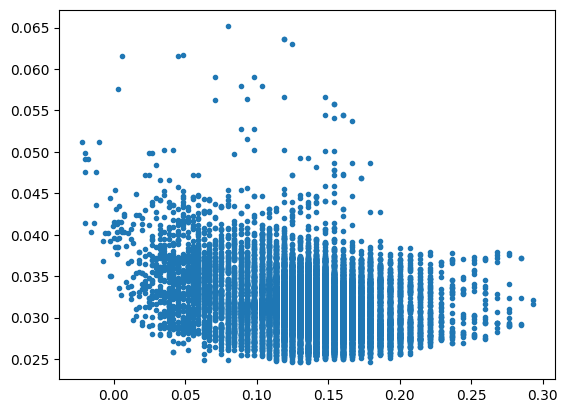

In [192]:
ind_embd = 29
ind_dw = 3
print(f"Corr embd {ind_embd} vs dw {ind_dw}: {corr_mat[ind_embd, ind_dw]}")

print(np.dot(embed_mat[ind_embd, :], dw_mat[ind_dw, :]) / (np.linalg.norm(embed_mat[ind_embd, :]) * np.linalg.norm(dw_mat[ind_dw, :])))
plt.plot(embed_mat[ind_embd, :], dw_mat[ind_dw, :], '.')
print(np.corrcoef(embed_mat[ind_embd, :], dw_mat[ind_dw, :]))

# CCA

In [193]:
cca = CCA(n_components=6)
X_c, Y_c = cca.fit_transform(embed_mat.T, dw_mat.T)
# print(X_c.shape, Y_c.shape)
corrs = [np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(cca.n_components)]
print("Canonical correlations:", np.round(corrs, 3))

Canonical correlations: [0.88  0.768 0.674 0.65  0.55  0.526]


(6, 16384) (6, 16384)


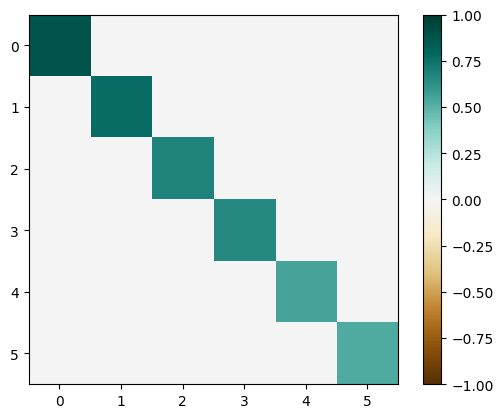

In [194]:

plt.imshow(au.correlation_two_matrices(X_c.T, Y_c.T), vmin=-1, vmax=1, cmap='BrBG')
plt.colorbar()

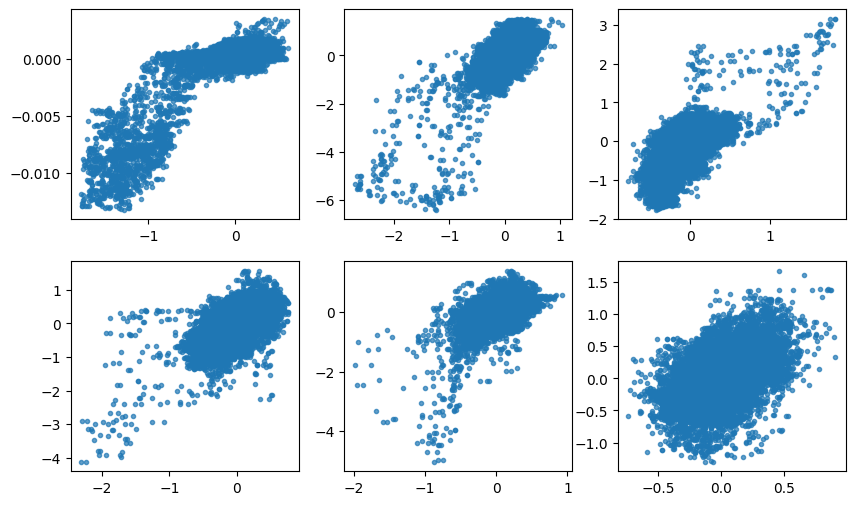

In [195]:
fig, ax = plt.subplots(2, 3, figsize=(10, 6))
ax = ax.flatten()
for ii in range(cca.n_components):
    ax[ii].plot(X_c[:, ii], Y_c[:, ii], '.', label=f'Component {ii + 1} (corr={corrs[ii]:.2f})', alpha=0.7)
# plt.xlabel("X canonical variate")
# plt.ylabel("Y canonical variate")
# plt.legend()
# plt.title("Canonical Correlation Analysis (CCA)")
# plt.show()

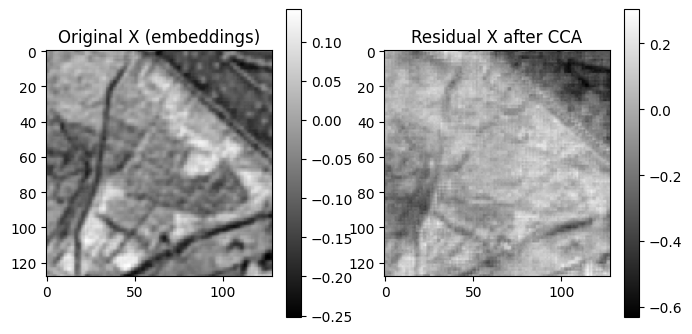

In [197]:
X_hat = X_c @ cca.x_weights_.T
X_residual = X - X_hat

orig_dim = 128 
assert orig_dim ** 2 == X.shape[0]
X_residual_img = X_residual.T.reshape(-1, orig_dim, orig_dim)
X_img = X.T.reshape(-1, orig_dim, orig_dim)


ind_plot += 1

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(X_img[ind_plot, ...], cmap='gray')
ax[0].set_title('Original X (embeddings)')
# colorbar
fig.colorbar(ax[0].imshow(X_img[ind_plot, ...], cmap='gray'), ax=ax[0])
ax[1].imshow(X_residual_img[ind_plot, ...], cmap='gray')
ax[1].set_title('Residual X after CCA')
# colorbar
fig.colorbar(ax[1].imshow(X_residual_img[ind_plot, ...], cmap='gray'), ax=ax[1])
plt.show()


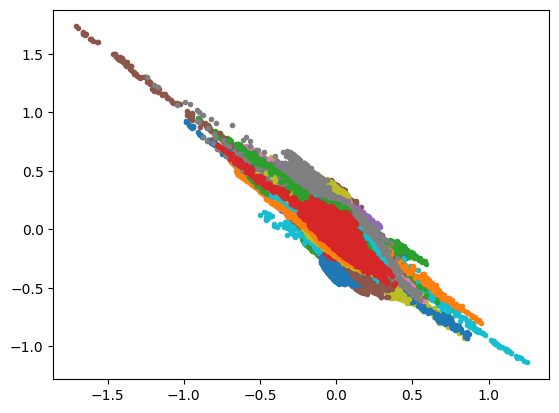

In [198]:
plt.plot(X_hat, X_residual, '.');

(64, 16384) (9, 16384)
(64, 16384) (9, 16384)


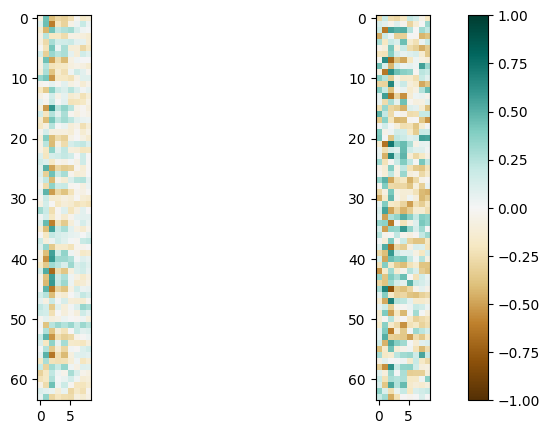

In [199]:
embed_mat = data_alpha.values.reshape(data_alpha.shape[0], -1)
dw_mat = data_dyn.values.reshape(data_dyn.shape[0], -1)
assert embed_mat.shape[1] == dw_mat.shape[1]

corr_mat = au.correlation_two_matrices(embed_mat, dw_mat)

fig, ax = plt.subplots(1,2, figsize=(10,5))
im = ax[0].imshow(corr_mat, vmin=-1, vmax=1, cmap='BrBG')
# fig.colorbar(im, ax=ax)

im = ax[1].imshow(au.correlation_two_matrices(X_residual.T, dw_mat), vmin=-1, vmax=1, cmap='BrBG')
fig.colorbar(im, ax=ax)

x_weights: (64, 6)
Min, max: -0.323854423284193, 0.6137272704491961
y_weights: (9, 6)
Min, max: -0.8045286561378923, 0.7935876447259369
x_loadings: (64, 6)
Min, max: -1.8142082293811468, 2.0567782486649677
y_loadings: (9, 6)
Min, max: -392.1528884163711, 284.97170455994564


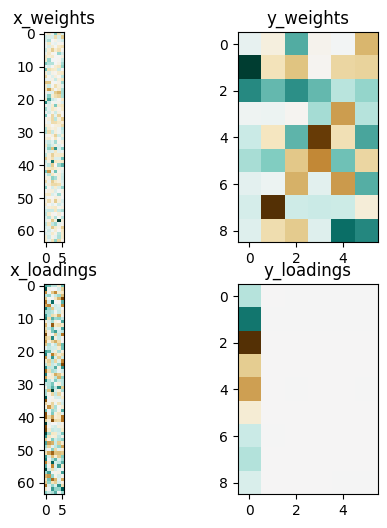

In [200]:
dict_outcome_cca = {
    'x_weights': cca.x_weights_,
    'y_weights': cca.y_weights_,
    'x_loadings': cca.x_loadings_,
    'y_loadings': cca.y_loadings_
}

fig, ax = plt.subplots(2, 2, figsize=(6, 6))
ax = ax.flatten()
for ii, (key, val) in enumerate(dict_outcome_cca.items()):
    print(f"{key}: {val.shape}")
    print(f'Min, max: {np.min(val)}, {np.max(val)}')
    im = ax[ii].imshow(val, cmap='BrBG', vmin=-np.max(np.abs(val)), vmax=np.max(np.abs(val)))
    ax[ii].set_title(key)

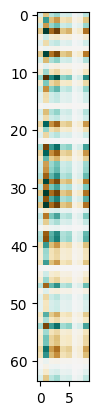

In [186]:
plt.imshow(np.dot(dict_outcome_cca['x_loadings'], dict_outcome_cca['y_loadings'].T), cmap='BrBG')